In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
%matplotlib inline
%run "C:\Users\anasofiaccruz\Desktop\cingulate_silencing_repo\data_prep_functions.ipynb"
%run "C:\Users\anasofiaccruz\Desktop\cingulate_silencing_repo\data_analysis_functions.ipynb"

#### <font color='darkorange'> Read the data (test runs below 15 seconds)

In [36]:
file_path = "C:/Users/anasofiaccruz/Desktop/Optogenetics processed data/below15_runs.csv"
below15 = pd.read_csv(file_path)

In [37]:
below15.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,2.989453,4.061312,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971


#### <font color='darkorange'> Remove baseline trials

In [38]:
below15 = below15[(below15['stim_condition']!=-1)]
below15['stim_condition'].unique()

array([1, 3, 0], dtype=int64)

#### <font color='darkorange'>Calculation of time spent in choice point

In [39]:
below15['time_in_cp'] = below15['latency_to_cp_exit']-below15['latency_to_cp_entry']
# Drop runs with time in cp below zero (only 6 runs, from the same rat and session)
below15 = below15[below15['time_in_cp']>=0]
below15.groupby(['group','stim_condition'])['time_in_cp'].count()

group  stim_condition
CTRL   0                  954
       1                  808
       3                  937
NPHR   0                 1195
       1                 1190
       3                 1161
Name: time_in_cp, dtype: int64

#### <font color='darkorange'> Histograms, cumulative distributions and qq plots within group

<Figure size 1800x1200 with 0 Axes>

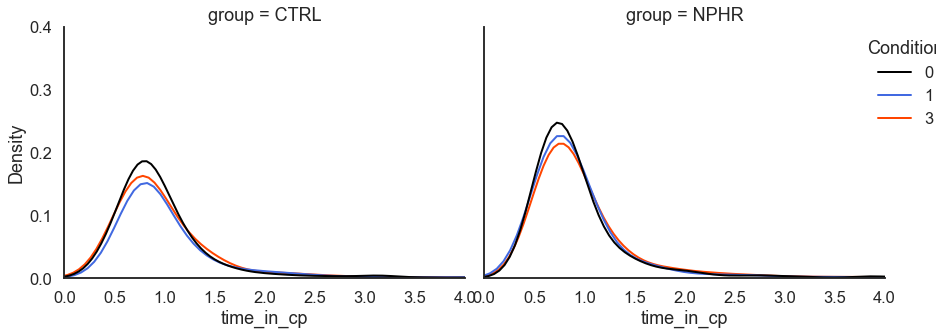

In [40]:
#g = plot_latency_distributions_within_group(sample_and_none,'hist', 'time_in_cp', ['black','royalblue'])
#g.set(xlim=[0,5], ylim=[0,0.08])
a = plot_latency_distributions_within_group(below15,
                                            'kde', 
                                            'time_in_cp',
                                            ['black','royalblue', 'orangered'])
a.set(xlim=[0,4], ylim=[0,0.4])

<Figure size 1800x1200 with 0 Axes>

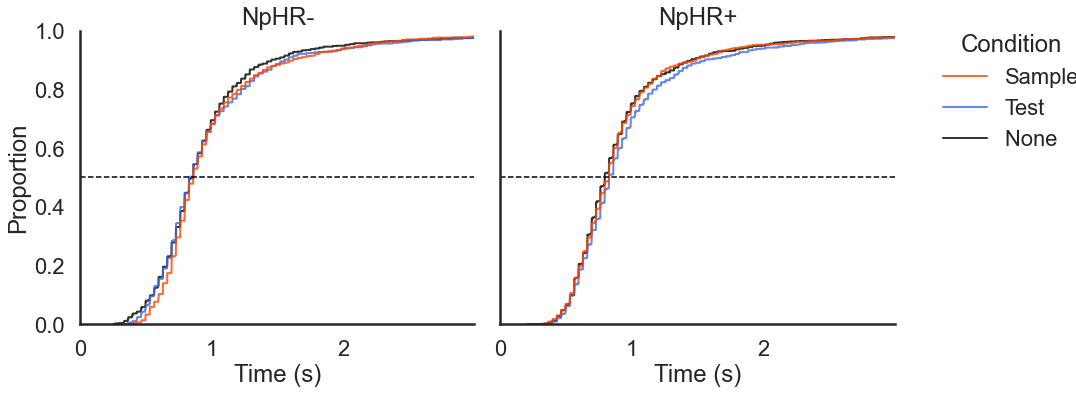

In [28]:
 g = plot_cumulative_distributions_within_group(below15, 'time_in_cp')
# subplot specs
axes = g.axes.flatten()
xticks = range(0,3)
xlim = [0,3]

axes[0].set(title="NpHR-", xlabel='Time (s)', xlim=xlim, xticks=xticks, xticklabels=xticks)
axes[0].axhline(0.5, linestyle='dashed', c='black', linewidth=1.5)
axes[1].set(title="NpHR+", xlabel='Time (s)', xlim=xlim, xticks=xticks, xticklabels=xticks)
axes[1].axhline(0.5, linestyle='dashed', c='black', linewidth=1.5)

#### <font color='darkorange'> Inference testing on latency to choice point distributions within group

In [41]:
results = inference_testing_kruskal_within_group(below15, 'time_in_cp')
results

,group,h,p
0,CTRL,4.441347,0.108536
1,NPHR,9.199175,0.010056


In [42]:
nphr_none = below15[(below15['stim_condition']==0) & (below15['group']=='NPHR')]
nphr_sample= below15[(below15['stim_condition']==1) & (below15['group']=='NPHR')]
nphr_test= below15[(below15['stim_condition']==3) & (below15['group']=='NPHR')]

In [44]:
a = [nphr_none, nphr_none]
b = [nphr_sample, nphr_test]
#Alpha with bonferroni correction = 0.05/2 = 0.025
results = inference_testing_mannwhitneyu(a,b, 'time_in_cp')
results

,a_group,b_group,a_condition,b_condition,a_outcome,b_outcome,u,p
0,NPHR,NPHR,0.0,1.0,1.0,1.0,701905.0,0.587587
1,NPHR,NPHR,0.0,3.0,1.0,1.0,646496.5,0.004246


#### <font color='darkorange'> Histograms, cumulative distributions and qq plots within condition

<Figure size 1800x1200 with 0 Axes>

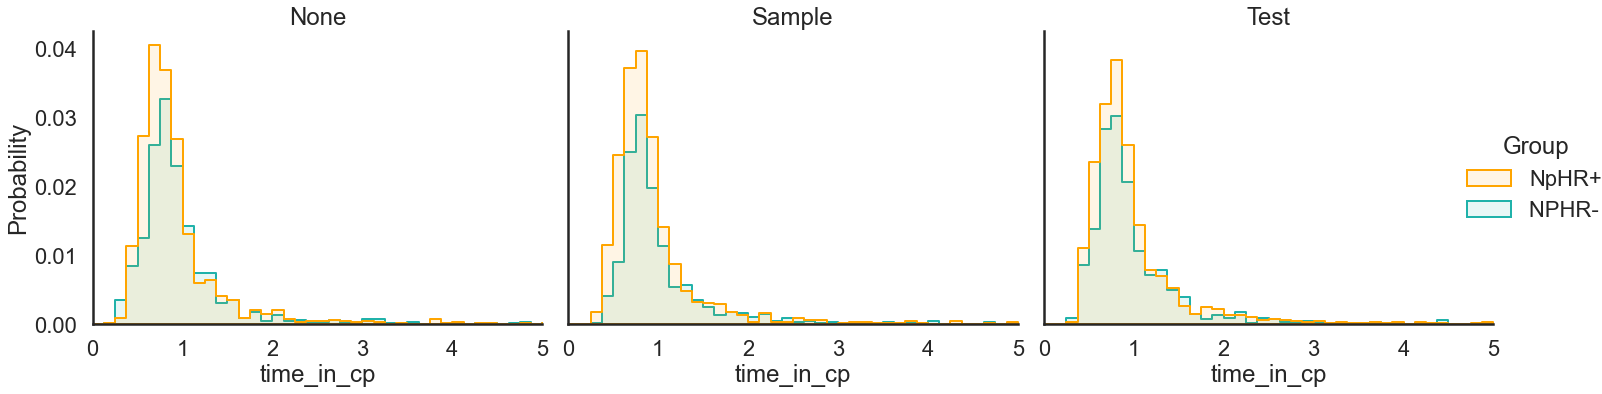

<Figure size 1800x1200 with 0 Axes>

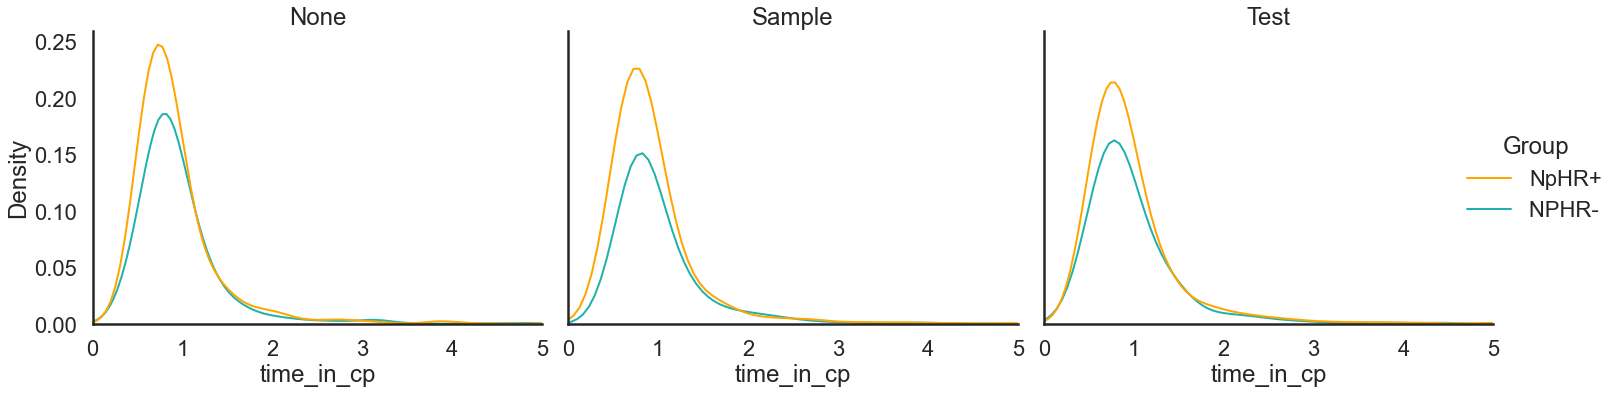

In [34]:
g = plot_latency_distributions_within_condition(below15,'hist','time_in_cp')
g.set(xlim=[0,5])
a = plot_latency_distributions_within_condition(below15,'kde','time_in_cp')
a.set(xlim=(0,5))

<Figure size 1800x1200 with 0 Axes>

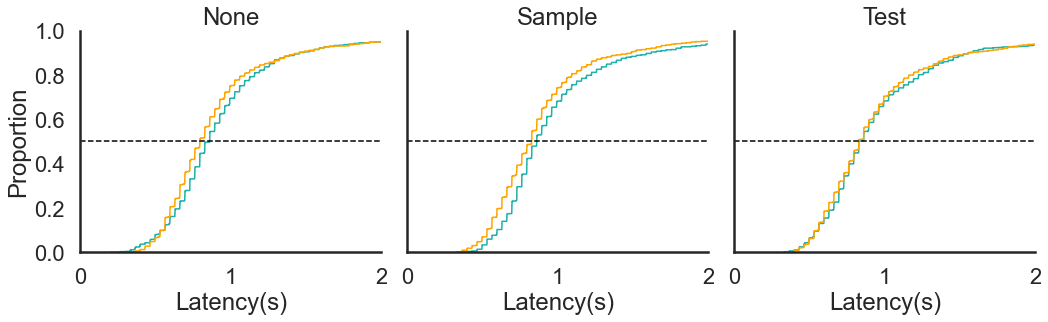

In [32]:
g = plot_cumulative_distributions_within_condition(below15, 'time_in_cp')
g.set(xlabel='Latency(s)', xlim=[0,2], xticks=range(0,3), xticklabels=range(0,3))

#### <font color='darkorange'>  Inference testing on time in cp distributions within conditions

In [33]:
a = [ctrl_none, ctrl_sample, ctrl_test]
b = [nphr_none, nphr_sample, nphr_test]
results = inference_testing_mannwhitneyu(a,b,'time_in_cp')
results

,a_group,b_group,a_condition,b_condition,a_outcome,b_outcome,u,p
0,CTRL,NPHR,0.0,0.0,1.0,1.0,619309.0,5.625057e-04
1,CTRL,NPHR,1.0,1.0,1.0,1.0,545033.0,3.805478e-07
2,CTRL,NPHR,3.0,3.0,1.0,1.0,560574.0,2.275659e-01
